In [20]:
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
import tensorflow_model_optimization as tfmot

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.qlayers import QDense, QActivation
from qkeras import QConv1D
from qkeras.utils import load_qmodel

import hist
from hist import Hist

import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import cm
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

import hls4ml
import hls4ml.utils
import hls4ml.converters



In [21]:
os.environ['PATH'] += os.pathsep + '/tools/Xilinx/Vitis_HLS/2022.1/bin'

model = load_qmodel("../models/quantized_merged_pruned_gamma30.h5")


config = hls4ml.utils.config_from_keras_model(model, granularity='name')

for Layer in config['LayerName'].keys():
        if "Dense" in Layer:

            config['LayerName'][Layer]['Strategy'] = 'Latency'
            config['LayerName'][Layer]['ReuseFactor'] = 1

        else:
            config['LayerName'][Layer]['Strategy'] = 'Latency'
            config['LayerName'][Layer]['ReuseFactor'] = 1

hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       backend='Vitis',
                                                       project_name='tau_nn', #I'm not very creative
                                                       clock_period=2.8, #1/360MHz = 2.8ns
                                                       hls_config=config,
                                                       output_dir='hardwareII_COM/testing60_pruned/hls4ml_prj',
                                                       part='xcvu9p-flga2104-2L-e')


# hls_model = hls4ml.converters.convert_from_keras_model(
#     model, hls_config=config, output_dir='model_3/hls4ml_prj', part='xcu250-figd2104-2L-e'
# )
hls_model.compile()

#hls_model.build(csim=False)
#hls4ml.converters.convert_from_keras_model


Interpreting Model
Topology:
Layer name: model_input, layer type: InputLayer, input shapes: [[None, 80]], output shape: [None, 80]
Layer name: Dense_1, layer type: QDense, input shapes: [[None, 80]], output shape: [None, 25]
Layer name: relu_1, layer type: Activation, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: Dense_2, layer type: QDense, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: relu_2, layer type: Activation, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: Dense_3, layer type: QDense, input shapes: [[None, 25]], output shape: [None, 15]
Layer name: relu_3, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: Dense_4, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: relu_4, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: Dense_5, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 10]
Layer name:

Done


In [22]:
num_samples = 10000

# Create a tensor of shape [10000, 80] with random values between 0 and 10
random_tensors = tf.random.uniform(shape=[num_samples, 80], minval=1, maxval=10, dtype=tf.float32).numpy()
print(random_tensors)
print(random_tensors.shape)
print(type(random_tensors))
y_qkeras = model.predict(np.ascontiguousarray(random_tensors))[0].flatten()
y_hls = hls_model.predict(np.ascontiguousarray(random_tensors))[0].flatten()
y_qkeras

[[7.460348  3.7703476 6.0344324 ... 8.521934  9.00225   6.466578 ]
 [6.157096  3.5847611 3.2526512 ... 6.2397738 8.385597  7.9326897]
 [1.7831181 4.6733785 5.3039336 ... 3.221678  8.119002  9.11684  ]
 ...
 [9.688991  4.047884  2.1023054 ... 4.2479887 5.1862664 2.0607257]
 [7.187459  2.8943896 2.263299  ... 9.169614  1.1631781 4.4476748]
 [8.521244  4.1267157 3.0646691 ... 1.1519074 6.910454  7.1379704]]
(10000, 80)
<class 'numpy.ndarray'>
313/313 [==============================] - 1s 987us/step


array([0.03058304, 0.03700378, 0.02907966, ..., 0.03700378, 0.02907966,
       0.02907966], dtype=float32)

In [23]:
y_hls

array([0.03027344, 0.03613281, 0.02929688, ..., 0.04199219, 0.03222656,
       0.02929688], dtype=float32)

In [24]:
print(np.max(abs(np.array(y_qkeras) - np.array(y_hls))))
print(np.min(abs(np.array(y_qkeras) - np.array(y_hls))))
y=abs(np.array(y_qkeras) - np.array(y_hls))

0.58645666
1.6354024e-06


(0.0, 0.05)

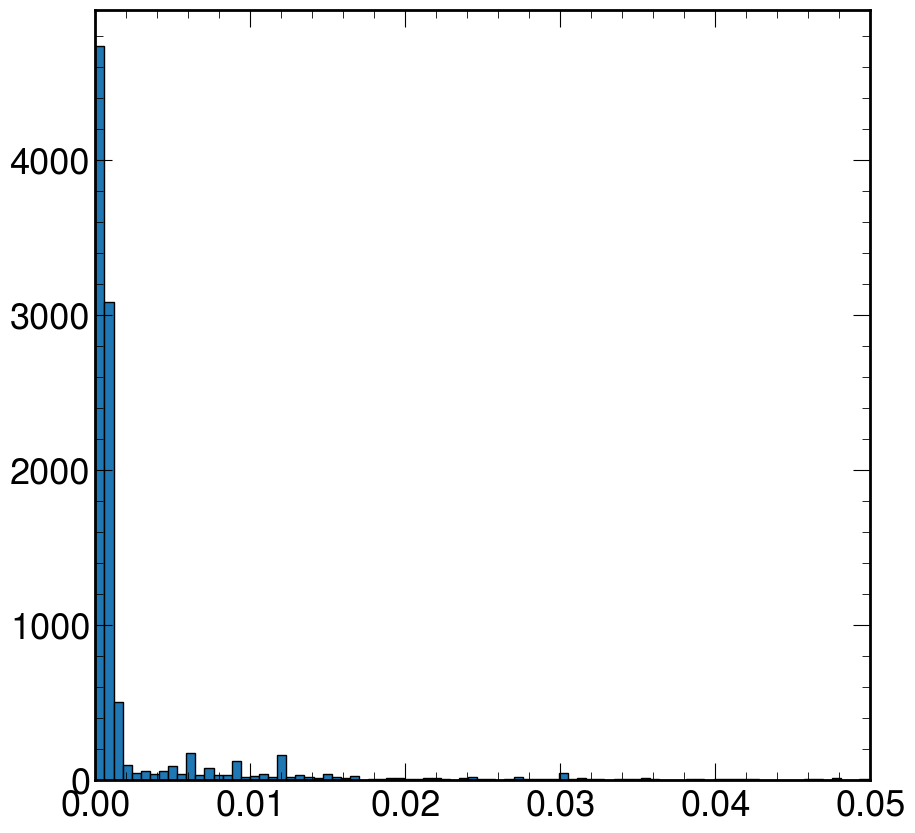

In [25]:
# Create x-coordinates for each bar
x1 = np.arange(len(y_qkeras))
x2 = np.arange(len(y_hls))

#plt.bar(y, x1, color = "black")
plt.hist(y, bins=1000, edgecolor='black')
plt.xlim(0, 0.05)

In [26]:
# ap_fixed<X,Y>, where Y is the number of bits representing the signed number above the binary point (i.e. the integer part)
# and X is the total number of bits. Additionally, integers in fixed precision data type (ap_int<N>, where N is a bit-size from 1 to 1024) can also be used. 

#min_width = 6
#max_width = 16

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
for layer_name in config['LayerName']:
    print(config['LayerName'][layer_name])
# Function to set accumulator width for a given layer
# def set_accumulator_width(layer_name):
#     total_bits=int(max(np.ceil(input_width + weight_width + np.log2(n_ops)), bias_width) + 1)
#     integer_bits=int(max(np.ceil(input_integers + weight_integers + np.log2(n_ops)), bias_integers) + 1)
#     config['LayerName'][layer_name]['accum_t'] = f'ap_fixed<{total_bits}, {integer_bits}>'

# # Iterate over each layer to optimize the accumulator width
# for layer_name in config['LayerName']:
#     # Define a range or method to select the optimal width
#     set_accumulator_width(layer_name, width)
    
#     # Convert the model with the updated configuration
#     hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                            hls_config=config,
#                                                            output_dir='model_{}_accum_width'.format(width))
    
#     # Compile and predict to test the model performance with the new accumulator width
#     hls_model.compile()
#     # Implement your method of evaluating the model here (e.g., using accuracy, resource utilization)
#     y_qkeras = model.predict(np.ascontiguousarray(random_tensors))[0].flatten()
#     y_hls = hls_model.predict(np.ascontiguousarray(random_tensors))[0].flatten()
#     print(np.max(abs(np.array(y_qkeras) - np.array(y_hls))))
#     print(np.min(abs(np.array(y_qkeras) - np.array(y_hls))))
#     y=abs(np.array(y_qkeras) - np.array(y_hls))

# Select the width that optimizes the metrics you care about for each layer
# Update the configuration or model accordingly
layer = model.layers[3]

# Accessing the layer by name (if you know the name)
# layer = model.get_layer('layer_name')

# Getting the number of neurons in this layer
number_of_neurons = layer.units
print("Number of neurons in the layer:", number_of_neurons)
model.summary()

Interpreting Model
Topology:
Layer name: model_input, layer type: InputLayer, input shapes: [[None, 80]], output shape: [None, 80]
Layer name: Dense_1, layer type: QDense, input shapes: [[None, 80]], output shape: [None, 25]
Layer name: relu_1, layer type: Activation, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: Dense_2, layer type: QDense, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: relu_2, layer type: Activation, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: Dense_3, layer type: QDense, input shapes: [[None, 25]], output shape: [None, 15]
Layer name: relu_3, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: Dense_4, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: relu_4, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: Dense_5, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 10]
Layer name:

In [27]:
# 'result' is input
n_ops_list = [2025, 650, 390, 240, 160, 11]
i = 0
for layer_name in config['LayerName']:
    #print(layer_name)
    #print(config['LayerName'][layer_name])
    #print(layer_name[:6])
    if layer_name[len(layer_name) - 6:] != 'linear' and layer_name[:5] == "Dense":
        print(config['LayerName'][layer_name])
        input_width = int(config['LayerName'][layer_name]['Precision']['result'][6:8].strip(","))
        weight_width = int(config['LayerName'][layer_name]['Precision']['weight'][6:8].strip(","))
        bias_width = int(config['LayerName'][layer_name]['Precision']['bias'][6:8].strip(","))
        input_integers = int(config['LayerName'][layer_name]['Precision']['result'][9:10].strip(">,"))
        weight_integers = int(config['LayerName'][layer_name]['Precision']['weight'][8:10].strip(">,"))
        bias_integers = int(config['LayerName'][layer_name]['Precision']['bias'][8:10].strip(">,"))
        print((input_width, weight_width, bias_width, input_integers, weight_integers, bias_integers))
        n_ops = n_ops_list[i]
        i += 1
        total_bits=int(max(np.ceil(input_width + weight_width + np.log2(n_ops)), bias_width) + 1)
        integer_bits=int(max(np.ceil(input_integers + weight_integers + np.log2(n_ops)), bias_integers) + 1)
        print(total_bits)
        print(integer_bits)
        #config['LayerName'][layer_name]['accum_t'] = f'ap_fixed<{total_bits}, {integer_bits}>'
        config['LayerName'][layer_name]['accum_t'] = 'float'

acc_width_opt_model = hls4ml.converters.convert_from_keras_model(model,
                                                       backend='Vitis',
                                                       project_name='tau_nn', #I'm not very creative
                                                       clock_period=2.8, #1/360MHz = 2.8ns
                                                       hls_config=config,
                                                       output_dir='hardwareII_COM/acc_width_optimize/hls4ml_prj',
                                                       part='xcvu9p-flga2104-2L-e')


# hls_model = hls4ml.converters.convert_from_keras_model(
#     model, hls_config=config, output_dir='model_3/hls4ml_prj', part='xcu250-figd2104-2L-e'
# )
acc_width_opt_model.compile()

acc_width_opt_model.build(csim=False)
#hls4ml.converters.convert_from_keras_model

{'Trace': False, 'Precision': {'result': 'fixed<16,6>', 'weight': 'fixed<9,3>', 'bias': 'fixed<9,3>'}}
(16, 9, 9, 6, 3, 3)
37
21
{'Trace': False, 'Precision': {'result': 'fixed<16,6>', 'weight': 'fixed<9,3>', 'bias': 'fixed<9,3>'}}
(16, 9, 9, 6, 3, 3)
36
20
{'Trace': False, 'Precision': {'result': 'fixed<16,6>', 'weight': 'fixed<9,3>', 'bias': 'fixed<9,3>'}}
(16, 9, 9, 6, 3, 3)
35
19
{'Trace': False, 'Precision': {'result': 'fixed<16,6>', 'weight': 'fixed<9,3>', 'bias': 'fixed<9,3>'}}
(16, 9, 9, 6, 3, 3)
34
18
{'Trace': False, 'Precision': {'result': 'fixed<16,6>', 'weight': 'fixed<9,3>', 'bias': 'fixed<9,3>'}}
(16, 9, 9, 6, 3, 3)
34
18
{'Trace': False, 'Precision': {'result': 'fixed<16,6>', 'weight': 'fixed<16,7>', 'bias': 'fixed<16,7>'}}
(16, 16, 16, 6, 7, 7)
37
18
Interpreting Model
Topology:
Layer name: model_input, layer type: InputLayer, input shapes: [[None, 80]], output shape: [None, 80]
Layer name: Dense_1, layer type: QDense, input shapes: [[None, 80]], output shape: [None, 2

AttributeError: 'NoneType' object has no attribute 'group'

In [28]:
y_qkeras = model.predict(np.ascontiguousarray(random_tensors))[0].flatten()
y_hls = acc_width_opt_model.predict(np.ascontiguousarray(random_tensors))[0].flatten()
y_qkeras

313/313 [==============================] - 0s 932us/step


array([0.03058304, 0.03700378, 0.02907966, ..., 0.03700378, 0.02907966,
       0.02907966], dtype=float32)

In [29]:
y_hls

array([0.03027344, 0.03710938, 0.02929688, ..., 0.04199219, 0.03222656,
       0.02929688], dtype=float32)

In [30]:
print(np.max(abs(np.array(y_qkeras) - np.array(y_hls))))
print(np.min(abs(np.array(y_qkeras) - np.array(y_hls))))
y=abs(np.array(y_qkeras) - np.array(y_hls))

0.59231603
1.6354024e-06


(0.0, 0.05)

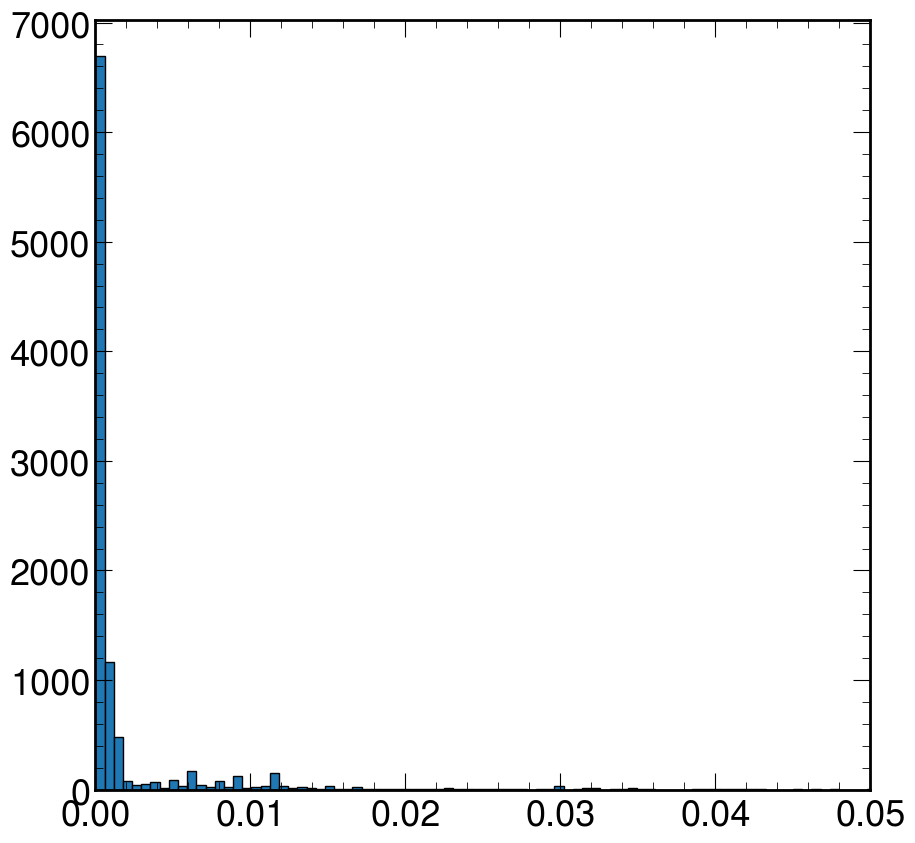

In [31]:
# Create x-coordinates for each bar
x1 = np.arange(len(y_qkeras))
x2 = np.arange(len(y_hls))

#plt.bar(y, x1, color = "black")
plt.hist(y, bins=1000, edgecolor='black')
plt.xlim(0, 0.05)